# Simulating 1-million-neuron networks with 1GB GPU memory

In [1]:
import brainpy as bp
import brainpy.math as bm
import jax

# # if you want to see GPU memory usage
# bm.disable_gpu_memory_preallocation()

assert bp.__version__ >= '2.4.1'

In [2]:
bm.set(dt=0.4)

In [3]:
_default_g_max = dict(type='homo', value=1., prob=0.1, seed=123)
_default_uniform = dict(type='uniform', w_low=0.1, w_high=1., prob=0.1, seed=123)
_default_normal = dict(type='normal', w_mu=0.1, w_sigma=1., prob=0.1, seed=123)

In [4]:
class Exponential(bp.synapses.TwoEndConn):
  def __init__(
      self,
      pre: bp.NeuGroup,
      post: bp.NeuGroup,
      output: bp.SynOut = bp.synouts.CUBA(),
      g_max_par=_default_g_max,
      delay_step=None,
      tau=8.0,
      method: str = 'exp_auto',
      name: str = None,
      mode: bm.Mode = None,
  ):
    super().__init__(pre, post, None, output=output, name=name, mode=mode)
    self.tau = tau
    self.g_max_par = g_max_par
    self.g = bp.init.variable_(bm.zeros, self.post.num, self.mode)
    self.delay_step = self.register_delay(f"{self.pre.name}.spike", delay_step, self.pre.spike)
    self.integral = bp.odeint(lambda g, t: -g / self.tau, method=method)

  def reset_state(self, batch_size=None):
    self.g.value = bp.init.variable_(bm.zeros, self.post.num, batch_size)

  def update(self):
    t = bp.share.load('t')
    dt = bp.share.load('dt')
    pre_spike = self.get_delay_data(f"{self.pre.name}.spike", self.delay_step)
    if self.g_max_par['type'] == 'homo':
      f = lambda s: bm.jitconn.event_mv_prob_homo(s,
                                                  self.g_max_par['value'],
                                                  conn_prob=self.g_max_par['prob'],
                                                  shape=(self.pre.num, self.post.num),
                                                  seed=self.g_max_par['seed'],
                                                  transpose=True)
    elif self.g_max_par['type'] == 'uniform':
      f = lambda s: bm.jitconn.event_mv_prob_uniform(s,
                                                     w_low=self.g_max_par['w_low'],
                                                     w_high=self.g_max_par['w_high'],
                                                     conn_prob=self.g_max_par['prob'],
                                                     shape=(self.pre.num, self.post.num),
                                                     seed=self.g_max_par['seed'],
                                                     transpose=True)
    elif self.g_max_par['type'] == 'normal':
      f = lambda s: bm.jitconn.event_mv_prob_normal(s,
                                                    w_mu=self.g_max_par['w_mu'],
                                                    w_sigma=self.g_max_par['w_sigma'],
                                                    conn_prob=self.g_max_par['prob'],
                                                    shape=(self.pre.num, self.post.num),
                                                    seed=self.g_max_par['seed'],
                                                    transpose=True)
    else:
      raise ValueError
    if isinstance(self.mode, bm.BatchingMode):
      f = jax.vmap(f)
    post_vs = f(pre_spike)
    self.g.value = self.integral(self.g.value, t, dt) + post_vs
    return self.output(self.g)

In [5]:
class EINet(bp.DynSysGroup):
  def __init__(self, scale=1.0, method='exp_auto'):
    super().__init__()
    num_exc = int(3200 * scale)
    num_inh = int(800 * scale)
    pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5., V_initializer=bp.init.Normal(-55., 2.))
    self.N = bp.neurons.LIF(num_exc + num_inh, **pars, method=method)
    self.E = Exponential(self.N[:num_exc], self.N,
                         g_max_par=dict(type='homo', value=0.6 / scale, prob=0.02, seed=123),
                         tau=5., method=method, output=bp.synouts.COBA(E=0.))
    self.I = Exponential(self.N[num_exc:], self.N,
                         g_max_par=dict(type='homo', value=6.7 / scale, prob=0.02, seed=12345),
                         tau=10., method=method, output=bp.synouts.COBA(E=-80.))

In [6]:
duration = 1e2
net = EINet(scale=250)

In [7]:
runner = bp.DSRunner(
  net,
  monitors=['N.spike'],
  inputs=('N.input', 20.),
  memory_efficient=True
)
runner.run(duration)

  0%|          | 0/250 [00:00<?, ?it/s]

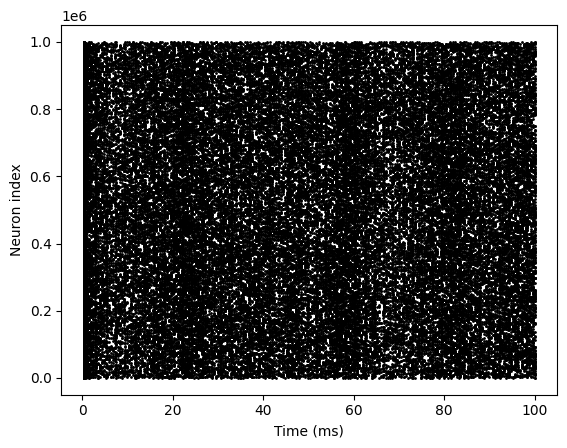

In [8]:
bp.visualize.raster_plot(runner.mon.ts, runner.mon['N.spike'], show=True)